# Sloan Digital Sky Survey Classification 🔭🔭
## Classification of Galaxies, Stars and Quasars based on the RD14 from the SDSS

### About the notebook

In this notebook we will try to classify observations of space in three different categories: stars, galaxies, quasars.

We are using data from the Sloan Digital Sky Survey (**Release 14**). 

### About the SDSS

The Sloan Digital Sky Survey is a project which offers public data of space observations. 

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

**For more information about this awesome project - please visit their website:**

http://www.sdss.org/

![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

## Data Acquisition

I you wish to find out more information about how to get data from the SDSS see their Data Access Guide:

http://www.sdss.org/dr14/data_access/

The query you can use to access the data is the following :

### Query

**SELECT TOP 10000** <br/>
p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z, p.run, p.rerun, p.camcol, p.field,  <br/>
s.specobjid, s.class, s.z as redshift, s.plate, s.mjd, s.fiberid  <br/>
**FROM** PhotoObj **AS** p <br/>
   **JOIN** SpecObj **AS** s **ON** s.bestobjid = p.objid <br/>
**WHERE** <br/>
   p.u **BETWEEN** 0 **AND** 19.6 <br/>
   **AND** g **BETWEEN** 0 **AND** 20 <br/>



The above query joins two tables (actually views): The image table (PhotoObj) which contains all image objects and the spectral table (SpecObj) which contains corresponding spectral data. 

### Feature Description

#### View "PhotoObj"
* objid = Object Identifier
* ra = J2000 Right Ascension (r-band)
* dec = J2000 Declination (r-band)

Right ascension (abbreviated RA) is the angular distance measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question. When paired with declination (abbreviated dec), these astronomical coordinates specify the direction of a point on the celestial sphere (traditionally called in English the skies or the sky) in the equatorial coordinate system.

Source: https://en.wikipedia.org/wiki/Right_ascension

* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit

The Thuan-Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further education: https://www.astro.umd.edu/~ssm/ASTR620/mags.html

* run = Run Number
* rereun = Rerun Number
* camcol = Camera column
* field = Field number

Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. A field can be identified by:
- **run** number, which identifies the specific scan,
- the camera column, or "**camcol**," a number from 1 to 6, identifying the scanline within the run, and
- the **field** number. The field number typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
- An additional number, **rerun**, specifies how the image was processed. 

#### View "SpecObj"

* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object)

The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift
* plate = plate number
* mjd = MJD of observation
* fiberid = fiber ID

In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

**Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.

The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
# import ensemble methods
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

## EDA
1. Load the data using the following link : https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/projects/boosting_model_eval/Skyserver_SQL2_27_2018+6_51_39+PM.csv

In [2]:
sdss_df = pd.read_csv('https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/projects/boosting_model_eval/Skyserver_SQL2_27_2018+6_51_39+PM.csv')

### Basic stats about our dataset

2. Let's take a first look at our dataset to see what we're working with! Display the first lines of the dataset and basic statistics.

In [3]:
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


We can tell that we have all the features as described in the above query. 

We notice that there are no categorical features at all - besides the class column. As some machine learning models can't handle categorical feature columns at all, we will encode this column to be a numerical column later on.

Let's find out about the types of columns we have:

In [4]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


The dataset has 10000 examples, 17 feature columns and 1 target column. 8 of the 17 features are 64 bit integers, 1 feature is an unsigned 64 bit integer, 8 are 64 bit floats and the target column is of the type object. 

In [5]:
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.577039e+05,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


From the above table we can tell that are no missing values at all. This means: **no imputing!**

Most variables do not show any outliers.

3. How is the target distributed?

In [6]:
100*sdss_df['class'].value_counts()/sdss_df.shape[0]

class
GALAXY    49.98
STAR      41.52
QSO        8.50
Name: count, dtype: float64

The most objects (50%) are galaxies, a little less (40%) are stars and only around (10%) of the rows are classified as QSOs.

### First Data Filtering

There is no need to know everything about stars, galaxy or quasars - yet we can already tell which features are **unlikely** to be related to the target variable 'class'.

**objid** and **specobjid** are just identifiers, we will not need them for classification.

The features 'run', 'rerun', 'camcol' and 'field' are values which describe parts of the camera when gathering observations, they do not describe caracteristics of the observed object e.g. 'run' represents the corresponding scan which captured the oject.

Source: http://www.sdss3.org/dr9/imaging/imaging_basics.php

4. Drop all the unnecessary features.

In [7]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


### Univariate Analysis

#### Redshift

5. Compare the distributions of redshift for the different classes of objects

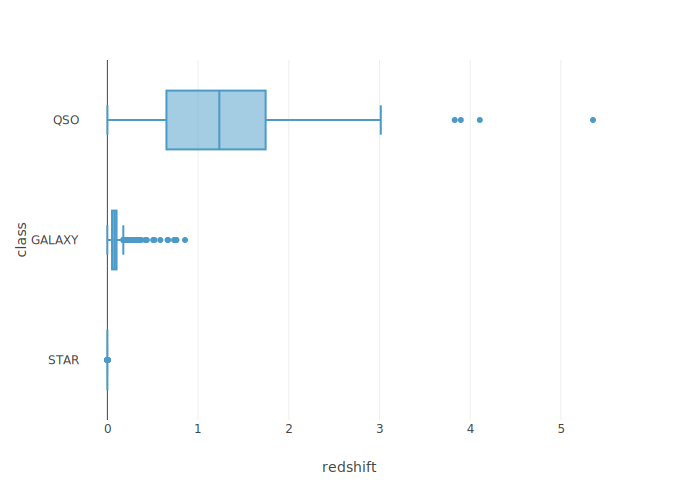

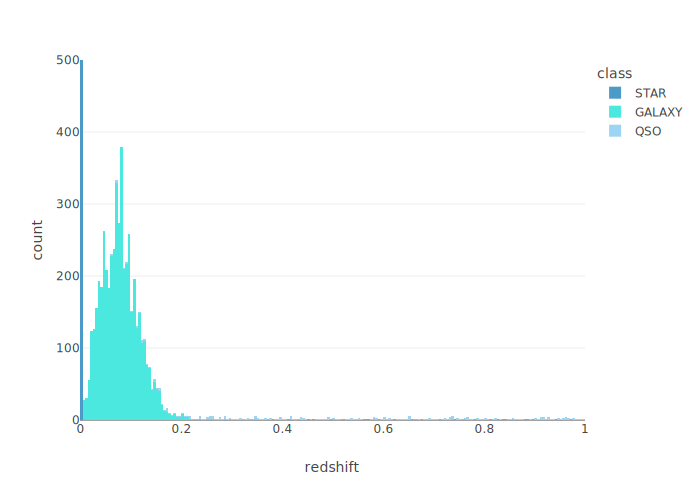

In [8]:
fig = px.box(sdss_df, y = 'class', x = 'redshift')
fig.show()

fig = px.histogram(sdss_df, x = 'redshift', color = 'class', range_x = [0, 1], range_y = [0, 500], nbins = 2000)
fig.show()

This is an interesting result.

We can cleary tell that the redshift values for the classes quite differ. 

* **Star:** The histogram looks like a truncated zero-centered normal distribution.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers.

**The redshift can be an estimate(!) for the distance from the earth to a object in space.**

Hence the distplot tells us that most of the stars observed are somewhat closer to the earth than galaxies or quasars. Galaxies tend to be a little further away and quasars are distant from very close to very far.  

Possible rookie explanation: Since galaxies and quasars radiate stronger due to their size and physical structure, they can be observed from further away than "small" stars.

As we can distinct the classes from each other just based on this column - 'redshift' is very likely to be helping a lot classifying new objects.

#### dec

6. Plot the distribution of the values of dec (position on celestial equator) for the different classes

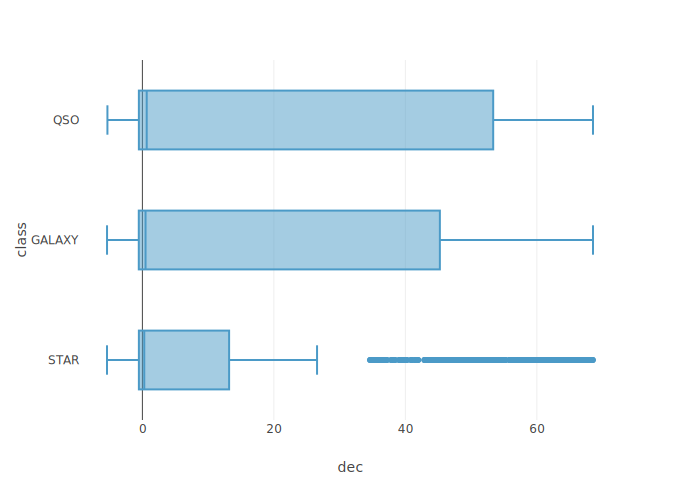

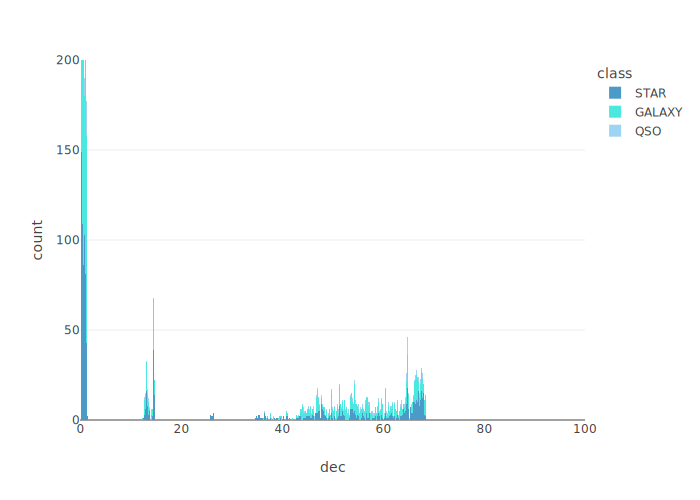

In [9]:
fig = px.box(sdss_df, y = 'class', x = 'dec')
fig.show()

fig = px.histogram(sdss_df, x = 'dec', color = 'class', range_x = [0, 100], range_y = [0, 200], nbins = 1000)
fig.show()

**First of all: what does this plot tell us?**

In this case we can observe a clear distinction between Stars and the other two classes. The difference between Galaxies and Quasars is smaller.

* **Star:** The largest part of the data points lay within a 0 to 10 range. Another large part consists of values between about 10 to 55. Only small amounts of the data are lower or higher than these ranges.

* **Galaxy:** The largest part of values lays between 0 and 45. There is a smaller amount of values in the range of 45 to 60. The rest of the data has smaller or higher values.

* **QSO:** This plot looks quite similiar to the GALAXY plot. Only the amount of data points in the range of 0 to 60 is even bigger.

Side Note: The fact that the distribution of dec values of galaxies and quasar objects is almost the same might indicate that one can find both galaxies and quasars at smiliar positions in the night sky.

### Multivariate Analysis

#### u,g,r,i,z filters

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations.

7. Plot the correlation matrix of these variables for the different classes

STAR


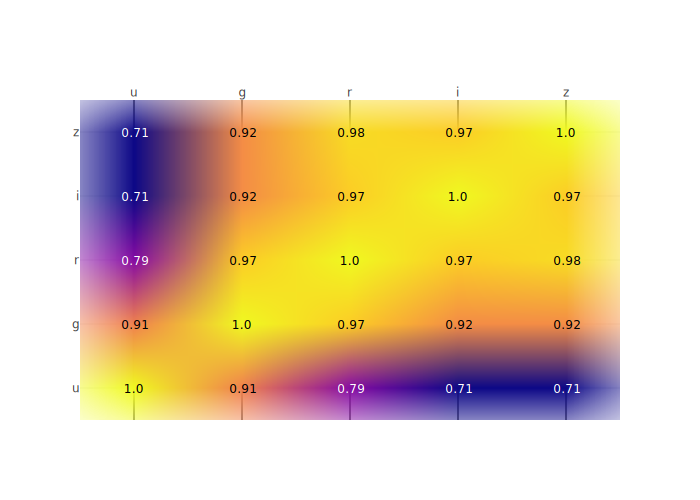

GALAXY


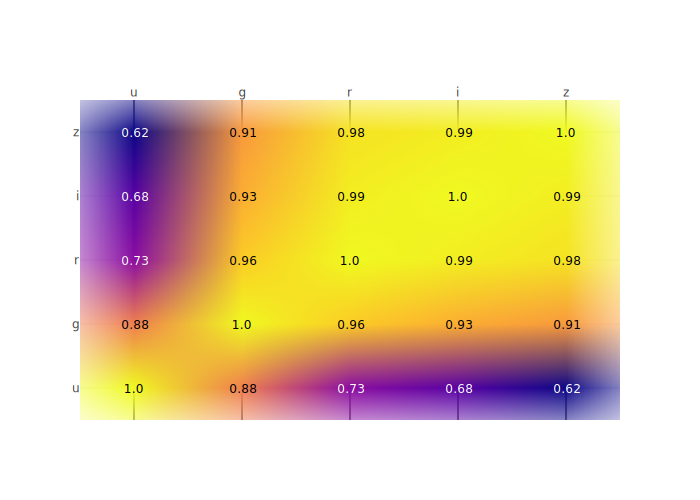

QSO


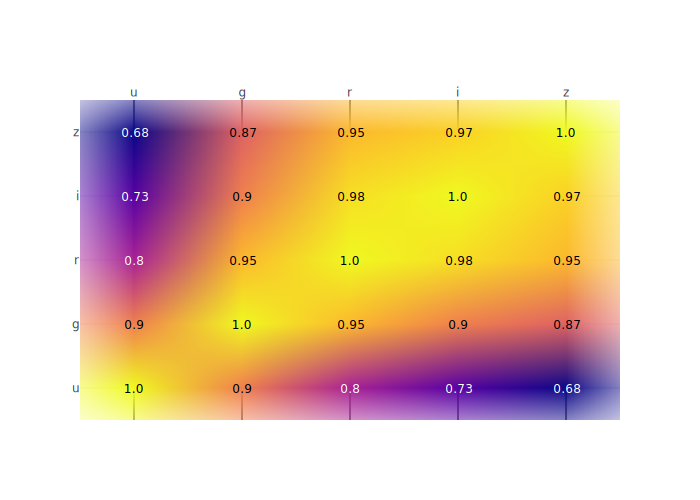

In [10]:
# Correlation matrix
import plotly.figure_factory as ff
print('STAR')
mask = sdss_df['class'] == 'STAR'
corr_matrix = sdss_df.loc[mask,['u', 'g', 'r', 'i', 'z']].corr().round(2)
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()

print('GALAXY')
mask = sdss_df['class'] == 'GALAXY'
corr_matrix = sdss_df.loc[mask,['u', 'g', 'r', 'i', 'z']].corr().round(2)
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()

print('QSO')
mask = sdss_df['class'] == 'QSO'
corr_matrix = sdss_df.loc[mask,['u', 'g', 'r', 'i', 'z']].corr().round(2)
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()

The correlation matrices look very similiar for every class.

There are high correlations between the different bands. Intuitively one would think that if one of the bands captures some signal emitted by a celestial object, the other bands should capture some signal.

Remember: u, g, r, i, z capture light at wavelengths of 354, 476, 628, 769 and 925 nm.

The correlation are similar across the different categories, the different bands behave the same for the different classes!

#### Right ascension (ra) and declination (dec) 

8. Plot the right ascension versus the declination depending on the class 

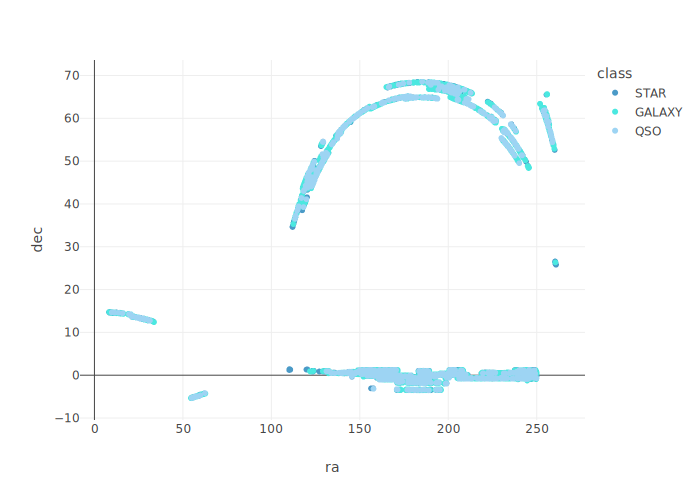

In [11]:
fig = px.scatter(sdss_df, x = 'ra', y = 'dec', color = 'class')
fig.show()

What this graph shows is that the three different categories of space objects are not clusterised spatially.

Why is that?

All SDSS images cover the same area of the sky. The plot above tells us that stars, galaxies and quasars are observed equally at all coordinates within this area. So wherever the SDSS "looks" - the chance of observing a star or galaxy or quasar is always the same.

## Preprocessing
8. Separate the target from the features and make a train/test splitting

In [12]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "class"

X = sdss_df.drop(target_variable, axis = 1)
Y = sdss_df.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
display(Y.head())
print()
print('X :')
display(X.head())

Separating labels from features...
...Done.

Y : 


0      STAR
1      STAR
2    GALAXY
3      STAR
4      STAR
Name: class, dtype: object


X :


,ra,dec,u,g,r,i,z,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,-0.000009,3306,54922,491
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,0.000590,3306,54922,512


In [13]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



9. Make the necessary preprocessings

In [14]:
print("Preprocessing X_train...")
print(X_train.head())
print()
preprocessor = StandardScaler()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) 
print() 

# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

Preprocessing X_train...
              ra        dec         u         g         r         i         z  \
749   210.309557  -0.760298  19.38266  18.81006  18.72689  18.71282  18.47746   
9986  131.050204  51.391819  19.37797  17.91853  17.10964  16.68906  16.36748   
7608  194.066814  68.223561  18.86498  17.57919  16.99713  16.61292  16.38148   
8477   19.506273  14.134257  18.91735  17.66109  16.85672  16.42755  16.09988   
1216  146.247636   0.718493  17.41267  17.09897  17.39865  17.65552  17.87561   

      redshift  plate    mjd  fiberid  
749   2.511341   4037  55631      260  
9986  0.093830    445  51873      613  
7608  0.066298    495  51988      452  
8477  0.057130    423  51821      102  
1216  0.000125   3826  55563      962  

...Done!
[[ 0.72366813 -0.61552858  0.91506763  1.52286141  1.7679204   1.88310226
   1.71364328  5.94894989  1.44590591  1.78163146 -0.45485713]
 [-0.93200133  1.45864878  0.90940562  0.57854142  0.25384137  0.09724927
  -0.04242427 -0.13316719 -

In [15]:
# Test pipeline
print("Preprocessing X_test...")
print(X_test.head())
print()
X_test = preprocessor.transform(X_test)
print("...Done!")
print(X_test[0:5,:])
print() 

# Label encoding
print("Encoding labels...")
print(Y_test.head())
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Preprocessing X_test...
              ra        dec         u         g         r         i         z  \
9668  178.893948  -0.017941  19.02523  18.07072  17.83271  17.74034  17.71727   
8182  185.958728  -1.010489  18.87700  17.90759  17.60999  17.46895  17.43112   
3749    9.886535  14.630850  19.37943  17.94113  17.30919  17.04600  16.93300   
7967  173.625877  -0.191402  18.47460  17.04496  16.54887  16.38259  16.28889   
6112  183.615732   0.856718  15.64312  14.63566  14.40994  14.35015  14.33967   

      redshift  plate    mjd  fiberid  
9668  0.000891    285  51930      352  
8182  0.000090   2558  54140      123  
3749 -0.000165   3133  54789       66  
7967  0.000361   2862  54471      193  
6112  0.000887    287  52023      535  

...Done!
[[ 6.74192141e-02 -5.86003778e-01  4.83559982e-01  7.39743019e-01
   9.30783789e-01  1.02494402e+00  1.08096193e+00 -3.66989084e-01
  -6.58600296e-01 -6.71105335e-01 -9.66005069e-03]
 [ 2.14997268e-01 -6.25479085e-01  3.04609198e-01  5.669

## Baseline model
10. Create a baseline (linear model with all features) and evaluate its performances

In [16]:
baseline = LogisticRegression(max_iter = 1000)
baseline.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [17]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = baseline.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = baseline.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[1 0 0 ... 0 1 2]

Predictions on test set...
...Done.
[2 2 2 ... 0 2 2]



In [18]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred, average = 'macro'))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred, average = 'macro'))
print()

accuracy on training set :  0.97875
accuracy on test set :  0.967

f1-score on training set :  0.9740716422428459
f1-score on test set :  0.9581169749498937



In [19]:
print('Classification report on train set:')
print(classification_report(Y_train, Y_train_pred))
print()
print('Classification report on test set:')
print(classification_report(Y_test, Y_test_pred))

Classification report on train set:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3998
           1       0.97      0.95      0.96       680
           2       0.97      0.99      0.98      3322

    accuracy                           0.98      8000
   macro avg       0.98      0.97      0.97      8000
weighted avg       0.98      0.98      0.98      8000


Classification report on test set:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1000
           1       0.95      0.92      0.93       170
           2       0.96      0.99      0.97       830

    accuracy                           0.97      2000
   macro avg       0.96      0.95      0.96      2000
weighted avg       0.97      0.97      0.97      2000



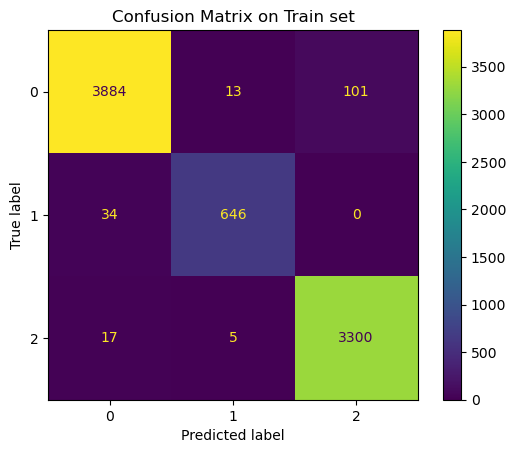

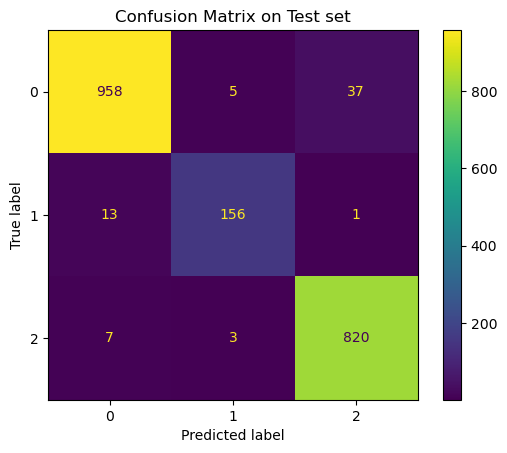

In [20]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(baseline, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(baseline, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

**The baseline is already really good at classifying the objects!**

11. Is the model underfitting/overfitting? Make what's necessary to be sure the score differences are significant.

In [21]:
val_scores = cross_val_score(baseline, X_train, Y_train, cv = 10)
print('average cross-validated accuracy: ', val_scores.mean())
print('std on cross-validated accuracy: ', val_scores.std())

average cross-validated accuracy:  0.97725
std on cross-validated accuracy:  0.005178078794301982


**The uncertainty on the test accuracy is about 0.005, so the model's overfitting a bit but it's not really a big issue (0.978 vs 0.967 is not a big difference anyway)**

12. Analyze the model's coefficients. Which feature is the most important?

In [22]:
column_names = X.columns
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  Index(['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift', 'plate', 'mjd',
       'fiberid'],
      dtype='object')


In [23]:
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = baseline.coef_[0].transpose(), columns=["coefficients"])
coefs

,coefficients
ra,0.023611
dec,0.151979
u,0.927614
g,-0.837030
r,0.406403
i,-0.291814
z,-0.580715
redshift,7.235061
plate,-0.322601
mjd,-0.348513


In [24]:
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
feature_importance

,coefficients
ra,0.023611
fiberid,0.081832
dec,0.151979
i,0.291814
plate,0.322601
mjd,0.348513
r,0.406403
z,0.580715
g,0.837030
u,0.927614


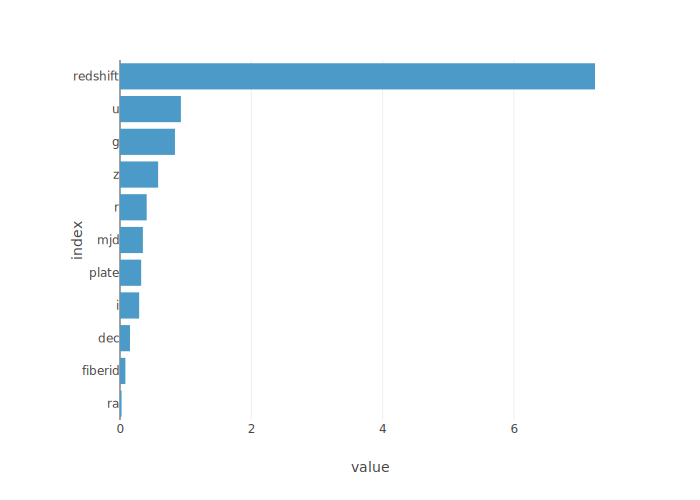

In [25]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

**We're rediscovering a very famous fact in Astrophysics: the redshift is very important to classify objects!**

## Feature selection
12. Use [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to implement a forward selection. Try to reduce the number of features to 3 and train the baseline once again. Are the model's performances still as good as before?

In [26]:
from sklearn.feature_selection import  SequentialFeatureSelector
feature_selector =  SequentialFeatureSelector(baseline, n_features_to_select = 3)
feature_selector.fit(X_train, Y_train)
features_list = X.columns
best_features = features_list[feature_selector.support_]
print("According to the forward selection algorithm, the following features should be kept: ")
print(best_features.to_list())

According to the forward selection algorithm, the following features should be kept: 
['g', 'redshift', 'plate']


In [27]:
X_reduced = X.loc[:, ['g', 'redshift', 'plate']]

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train_reduced, X_test_reduced, Y_train_reduced, Y_test_reduced = train_test_split(X_reduced, Y, test_size=0.2, 
                                                                    random_state=0, stratify = Y)
print("...Done.")
print()

print("Preprocessing X_train_reduced...")
print(X_train_reduced.head())
print()
preprocessor = StandardScaler()
X_train_reduced = preprocessor.fit_transform(X_train_reduced)
print("...Done!")
print(X_train_reduced[0:5,:]) 
print() 

# Label encoding
print("Encoding labels...")
print(Y_train_reduced.head())
encoder = LabelEncoder()
Y_train_reduced = encoder.fit_transform(Y_train_reduced)
print("...Done")
print(Y_train_reduced[0:5])

# Test pipeline
print("Preprocessing X_test_reduced...")
print(X_test_reduced.head())
print()
X_test_reduced = preprocessor.transform(X_test_reduced)
print("...Done!")
print(X_test_reduced[0:5,:])
print() 

# Label encoding
print("Encoding labels...")
print(Y_test_reduced.head())
Y_test_reduced = encoder.transform(Y_test_reduced)
print("...Done")
print(Y_test_reduced[0:5])


Dividing into train and test sets...
...Done.

Preprocessing X_train_reduced...
             g  redshift  plate
749   18.81006  2.511341   4037
9986  17.91853  0.093830    445
7608  17.57919  0.066298    495
8477  17.66109  0.057130    423
1216  17.09897  0.000125   3826

...Done!
[[ 1.52286141  5.94894989  1.44590591]
 [ 0.57854142 -0.13316719 -0.56885589]
 [ 0.21910815 -0.20243423 -0.54081077]
 [ 0.30585768 -0.22550011 -0.58119575]
 [-0.28954703 -0.36891619  1.32755548]]

Encoding labels...
749        QSO
9986    GALAXY
7608    GALAXY
8477    GALAXY
1216      STAR
Name: class, dtype: object
...Done
[1 0 0 0 2]
Preprocessing X_test_reduced...
             g  redshift  plate
9668  18.07072  0.000891    285
8182  17.90759  0.000090   2558
3749  17.94113 -0.000165   3133
7967  17.04496  0.000361   2862
6112  14.63566  0.000887    287

...Done!
[[ 0.73974302 -0.36698908 -0.6586003 ]
 [ 0.56695363 -0.36900448  0.6163311 ]
 [ 0.60247963 -0.3696475   0.93885005]
 [-0.34675511 -0.36832351  0.

In [28]:
baseline_reduced = LogisticRegression(max_iter = 1000)
baseline_reduced.fit(X_train_reduced, Y_train_reduced)

LogisticRegression(max_iter=1000)

In [29]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = baseline_reduced.predict(X_train_reduced)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = baseline_reduced.predict(X_test_reduced)
print("...Done.")
print(Y_test_pred)
print()

# Print scores
print("accuracy on training set : ", accuracy_score(Y_train_reduced, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test_reduced, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train_reduced, Y_train_pred, average = 'macro'))
print("f1-score on test set : ", f1_score(Y_test_reduced, Y_test_pred, average = 'macro'))
print()

Predictions on training set...
...Done.
[1 0 0 ... 0 1 2]

Predictions on test set...
...Done.
[2 2 2 ... 0 2 2]

accuracy on training set :  0.977375
accuracy on test set :  0.9655

f1-score on training set :  0.9655745503120432
f1-score on test set :  0.9460831304524243



**The scores are a bit deteriorated but still very good!**

## Non-linear model
13. By using all the features, try a non-linear model. Does it improves the performances?

Predictions on training set...
...Done.
[1 0 0 ... 0 1 2]

Predictions on test set...
...Done.
[2 2 2 ... 0 2 2]

accuracy on training set :  0.97125
accuracy on test set :  0.9565

f1-score on training set :  0.9680296401350565
f1-score on test set :  0.948378856758452

Classification report on train set:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3998
           1       0.98      0.94      0.96       680
           2       0.97      0.98      0.97      3322

    accuracy                           0.97      8000
   macro avg       0.97      0.96      0.97      8000
weighted avg       0.97      0.97      0.97      8000


Classification report on test set:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1000
           1       0.96      0.89      0.93       170
           2       0.94      0.98      0.96       830

    accuracy                           0.96      2000
   

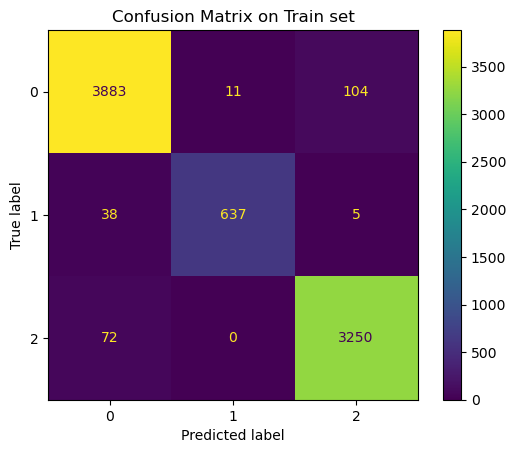

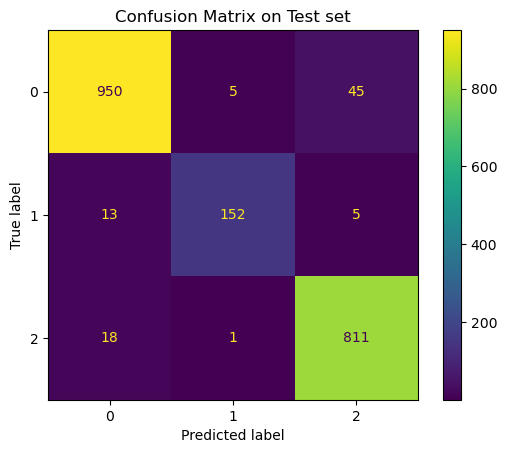

In [30]:
svm = SVC(kernel = 'rbf')
svm.fit(X_train, Y_train)

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = svm.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = svm.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred, average = 'macro'))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred, average = 'macro'))
print()

print('Classification report on train set:')
print(classification_report(Y_train, Y_train_pred))
print()
print('Classification report on test set:')
print(classification_report(Y_test, Y_test_pred))

# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svm, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svm, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

14. Depending on what model you chose, the model might be overfitting. If it's the case, make what's necessary to solve the problem.

In [31]:
# SVM
# Perform grid search
print("Grid search...")
svm = SVC(kernel = 'rbf', probability = True)

# Grid of values to be tested
params = {
    'C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0],
    'gamma': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
}
svm_opt = GridSearchCV(svm, param_grid = params, cv = 3, verbose = 1)
svm_opt.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", svm_opt.best_params_)
print("Best validation accuracy : ", svm_opt.best_score_)
print()
print("Accuracy on training set : ", svm_opt.score(X_train, Y_train))
print("Accuracy on test set : ", svm_opt.score(X_test, Y_test))

Grid search...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
...Done.
Best hyperparameters :  {'C': 5.0, 'gamma': 0.05}
Best validation accuracy :  0.9771246242381743

Accuracy on training set :  0.9825
Accuracy on test set :  0.968


## Ensemble methods
15. Implement a voting of your linear and non-linear models. Does it improve the scores?

In [32]:
# Voting
voting = VotingClassifier(estimators=[("logistic", baseline), ("svm", svm)], voting='soft') # soft: use probabilities for voting
voting.fit(X_train, Y_train)
print("Accuracy on training set : ", voting.score(X_train, Y_train))
print("Accuracy on test set : ", voting.score(X_test, Y_test))

Accuracy on training set :  0.977625
Accuracy on test set :  0.965


**The generalized performances are not improved compared to the non-linear model, so we'd better keep the SVM alone.**